In [1]:
## Backend library imports
import numpy as np
import os
import sys
import time
import torch
import scipy
from scipy.signal import butter, filtfilt
from sklearn.decomposition import NMF

## Plotting library imports
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import fastplotlib as fpl

## Demixing imports
import localnmf 
import masknmf
from masknmf.visualization import make_demixing_video, plot_ith_roi, get_roi_avg
from matplotlib.gridspec import GridSpec

import plotly.graph_objects as go
import plotly.subplots as sp

import os
import re
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%load_ext line_profiler

To silence this warning, use a fully namespaced name.
To silence this warning, use a fully namespaced name.
To silence this warning, use a fully namespaced name.
To silence this warning, use a fully namespaced name.
To silence this warning, use a fully namespaced name.
To silence this warning, use a fully namespaced name.


Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01,\x00\x00\x007\x08\x06\x00\x00\x00\xb6\x1bw\x99\x…

No windowing system present. Using surfaceless platform
No config found!
No config found!
Max vertex attribute stride unknown. Assuming it is 2048
Max vertex attribute stride unknown. Assuming it is 2048
Max vertex attribute stride unknown. Assuming it is 2048
Max vertex attribute stride unknown. Assuming it is 2048
Max vertex attribute stride unknown. Assuming it is 2048


Available devices:
✅ (default) | NVIDIA TITAN RTX | DiscreteGPU | Vulkan | 555.42.02
❗ | llvmpipe (LLVM 12.0.0, 256 bits) | CPU | Vulkan | Mesa 21.2.6 (LLVM 12.0.0)
❗ | NVIDIA TITAN RTX/PCIe/SSE2 | Unknown | OpenGL | 3.3.0 NVIDIA 555.42.02


# Decide which device the demixing is run on, cuda or cpu

In [2]:
device='cuda'

# Load the high-pass filtered PMD data, convert it to a rlocalnmf Signal Demixer object

In [3]:
filename = "/path/to/high_pass_thresholded_file.npz"
full_pmd_movie = np.load(filename, allow_pickle=True)['pmd'].item()

In [4]:
#Construct the SignalDemixer demixing object
num_frames, fov_dim1, fov_dim2 = full_pmd_movie.shape
highpass_pmd_demixer = localnmf.SignalDemixer(full_pmd_movie.u,
                                                full_pmd_movie.r,
                                                full_pmd_movie.s,
                                                full_pmd_movie.v,
                                                (fov_dim1, fov_dim2, num_frames), 
                                                data_order=full_pmd_movie.order,
                                                device=device)

# Run 1st pass demixing on this data

# Identify remaining signals here

Computing correlation data structure with MAD threshold  2and the robust corr term is 0.03
find superpixels!
find pure superpixels!
prepare iteration!


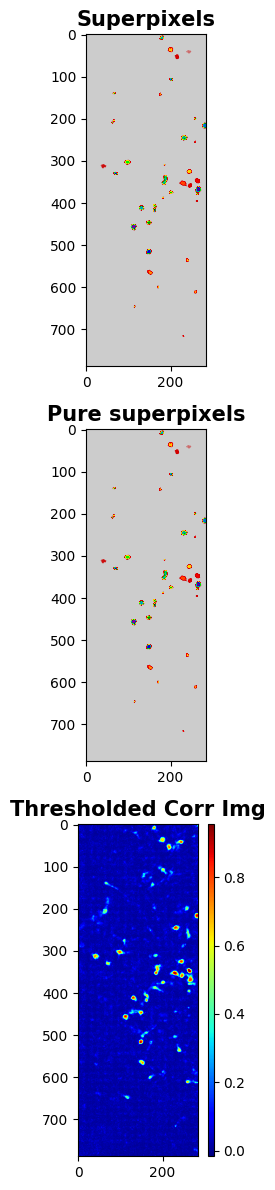

Identified 40 neurons here


In [5]:
init_kwargs = {
    #Worth modifying
    'mad_correlation_threshold':0.6,
    'min_superpixel_size':3,

    #Mostly stable
    'mad_threshold':2,
    'residual_threshold': 0.3,
    'patch_size':(40, 40),
    'robust_corr_term':0.03,
    'plot_en':True,
    'text':False,
}

highpass_pmd_demixer.initialize_signals(**init_kwargs, is_custom = False)
print(f"Identified {highpass_pmd_demixer.results[0].shape[1]} neurons here")

# Lock the above results and move to demixing

In [6]:
highpass_pmd_demixer.lock_results_and_continue()

Now in demixing state


# Demix the data

In [7]:
num_iters = 25
## Now run demixing...
localnmf_params = {
    'maxiter':num_iters,
    'support_threshold':np.linspace(0.9, 0.6, num_iters).tolist(),
    'deletion_threshold':0.2,
    'ring_model_start_pt':num_iters + 1, #No ring model needed
    'ring_radius':20,
    'merge_threshold':0.8,
    'merge_overlap_threshold':0.8,
    'update_frequency':num_iters + 1, #No support updates
    'c_nonneg':False, #For voltage data, the "C" term can be negative
    'denoise':False, 
    'plot_en': False
}

start_time = time.time()
with torch.no_grad():
    highpass_pmd_demixer.demix(**localnmf_params)
print(f"that took {time.time() - start_time}")
print(f"after this step {highpass_pmd_demixer.results.a.shape[1]} signals identified")



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 103.23it/s]


that took 0.9809067249298096
after this step 40 signals identified


# Visualize a demixing video. Things to check: are there missing neural signals in the demixing video? This is fine -- you can run a second pass of demixing on the "residual" to identify those signals. 

In [9]:
results = highpass_pmd_demixer.results

iw = make_demixing_video(results,
                    device,
                    v_range=[-1, 1])

iw.show()

# Part 2: Take the above spatial signals, and regress the (unfiltered) PMD data onto it. Note: the "support expansion", merging, are all disabled here (we do all that on the filtered data). At this stage we can just do alternating least squares updates to estimate A and C.

# Load the (unfiltered) PMD data and regress it directly onto the above spatial profiles

In [17]:
filename = "/path/to/your/decomposition.npz"
full_pmd_movie = np.load(filename, allow_pickle=True)['pmd'].item()

In [18]:
#Construct the SignalDemixer demixing object
num_frames, fov_dim1, fov_dim2 = full_pmd_movie.shape
unfiltered_pmd_demixer = localnmf.SignalDemixer(full_pmd_movie.u,
                                                full_pmd_movie.r,
                                                full_pmd_movie.s,
                                                full_pmd_movie.v,
                                                (fov_dim1, fov_dim2, num_frames), 
                                                data_order=full_pmd_movie.order,
                                                device=device)

# Initialize the signals using the "custom" option, where we provide pre-computed spatial footprints

In [19]:
unfiltered_pmd_demixer.initialize_signals(is_custom=True, spatial_footprints=highpass_pmd_demixer.results.a)
unfiltered_pmd_demixer.lock_results_and_continue()

Now in demixing state


# Using above spatial footprints, run unmixing on the unfiltered data. At the last iteration, turn on the background term. No need for support updates here

In [20]:
## Now run demixing...
num_iters = 25
localnmf_params = {
    'maxiter':num_iters,
    'support_threshold':np.linspace(0.8, 0.5, num_iters).tolist(),
    'deletion_threshold':0.2,
    'ring_model_start_pt':max(0, num_iters - 1), # Ring model is run at last step
    'ring_radius':20,
    'merge_threshold':0.8,
    'merge_overlap_threshold':0.8,
    'update_frequency':num_iters + 1, # No support updates here
    'c_nonneg':False,
    'denoise':False,
    'plot_en': False
}

start_time = time.time()
with torch.no_grad():
    unfiltered_pmd_demixer.demix(**localnmf_params)
print(f"that took {time.time() - start_time}")
print(f"Identified {unfiltered_pmd_demixer.results.a.shape[1]} neurons")




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 20.57it/s]


that took 1.907364845275879
Identified 40 neurons


In [21]:
unfiltered_pmd_demixer.lock_results_and_continue()

Now in the initialization state


# Run a second pass of demixing to pick up any missing signals. This uses a correlation statistic between adjacent pixels to search for remaining signals. Normally, this would be impossible - the optostim waveform artificially raises the correlation of all terms. The background term above accounts for this in the computations. 

Computing correlation data structure with MAD threshold  1and the robust corr term is 0.03
find superpixels!
find pure superpixels!
prepare iteration!


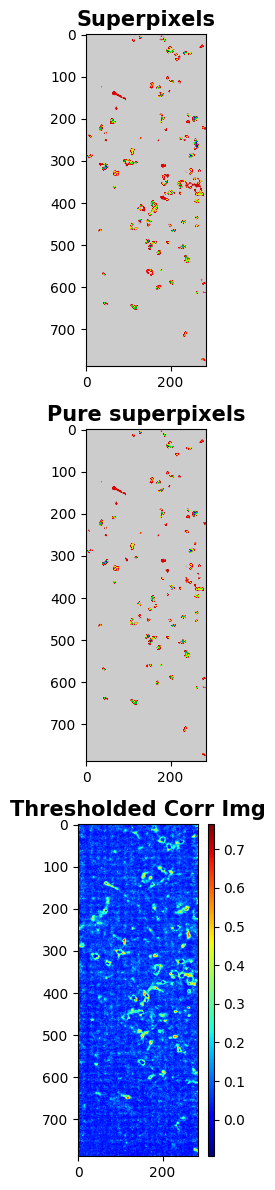

In [22]:
init_kwargs = {
    #In the second pass, these params are smaller to pick up "smaller" signals
    'mad_correlation_threshold':0.5,
    'min_superpixel_size':5,

    #Mostly stable
    'mad_threshold':1,
    'residual_threshold': 0.3,
    'patch_size':(40, 40),
    'robust_corr_term':0.03,
    'plot_en':True,
    'text':False,
}


# unfiltered_pmd_demixer.state.factorized_ring_term = None


unfiltered_pmd_demixer.initialize_signals(**init_kwargs, is_custom = False)

In [23]:
unfiltered_pmd_demixer.lock_results_and_continue()

Now in demixing state


# Now run demixing with the support updates turned on to merge things together as needed

In [24]:
## Now run demixing...
num_iters = 25
localnmf_params = {
    'maxiter':num_iters,
    'support_threshold':np.linspace(0.8, 0.5, num_iters).tolist(),
    'deletion_threshold':0.2,
    'ring_model_start_pt':max(0, num_iters + 1), #No ring model needed
    'ring_radius':20,
    'merge_threshold':0.8,
    'merge_overlap_threshold':0.8,
    'update_frequency':4, #No support updates
    'c_nonneg':False,
    'denoise':False,
    'plot_en': False
}

start_time = time.time()
with torch.no_grad():
    unfiltered_pmd_demixer.demix(**localnmf_params)
print(f"that took {time.time() - start_time}")
print(f"Identified {unfiltered_pmd_demixer.results.a.shape[1]} neurons")




 16%|█████████████████████████████████████▊                                                                                                                                                                                                      | 4/25 [00:00<00:03,  5.75it/s]

merging {np.int64(96), np.int64(5)}
merging {np.int64(8), np.int64(58)}
merging {np.int64(18), np.int64(47)}
merging {np.int64(26), np.int64(86)}
merging {np.int64(113), np.int64(27)}
merging {np.int64(89), np.int64(34)}
merging {np.int64(72), np.int64(37)}
merging {np.int64(74), np.int64(39)}


 32%|███████████████████████████████████████████████████████████████████████████▌                                                                                                                                                                | 8/25 [00:01<00:03,  4.83it/s]

merging {np.int64(10), np.int64(37)}
merging {np.int64(24), np.int64(98)}


 48%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                          | 12/25 [00:02<00:02,  4.96it/s]

merging {np.int64(65), np.int64(2)}


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                    | 16/25 [00:03<00:01,  5.13it/s]

merging {np.int64(11), np.int64(71)}


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:04<00:00,  5.45it/s]


that took 5.341511011123657
Identified 140 neurons


RFBOutputContext()

JupyterWgpuCanvas()
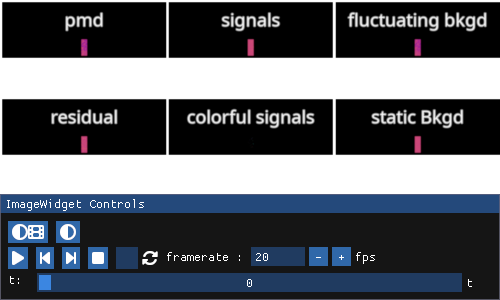

In [25]:
results = unfiltered_pmd_demixer.results

iw = make_demixing_video(results,
                    device,
                    v_range=[-1, 1])

iw.show()

# Now turn off the background model (since this was taking away some of the signal from the cells

In [26]:
final_pmd_demixer = localnmf.SignalDemixer(full_pmd_movie.u,
                                                full_pmd_movie.r,
                                                full_pmd_movie.s,
                                                full_pmd_movie.v,
                                                (fov_dim1, fov_dim2, num_frames), 
                                                data_order=full_pmd_movie.order,
                                                device=device)

In [27]:
final_pmd_demixer.initialize_signals(is_custom=True, spatial_footprints=unfiltered_pmd_demixer.results.a)
final_pmd_demixer.lock_results_and_continue()

Now in demixing state


In [29]:
## Now run demixing...
num_iters = 25
localnmf_params = {
    'maxiter':num_iters,
    'support_threshold':np.linspace(0.7, 0.6, num_iters).tolist(),
    'deletion_threshold':0.2,
    'ring_model_start_pt':num_iters+1, #No ring model needed
    'ring_radius':20,
    'merge_threshold':0.8,
    'merge_overlap_threshold':0.8,
    'update_frequency':num_iters + 1, #No support updates
    'c_nonneg':False,
    'denoise':False,
    'plot_en': False
}

start_time = time.time()
with torch.no_grad():
    final_pmd_demixer.demix(**localnmf_params)
print(f"that took {time.time() - start_time}")
print(f"Identified {final_pmd_demixer.results.a.shape[1]} neurons")




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 101.52it/s]


that took 1.037393569946289
Identified 140 neurons


RFBOutputContext()

JupyterWgpuCanvas()
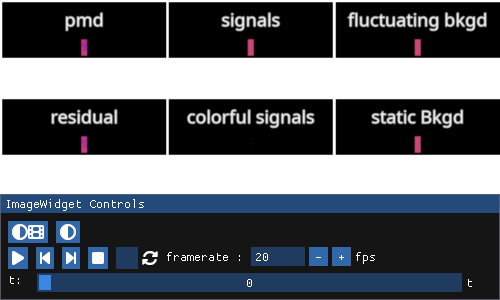

In [30]:
results = final_pmd_demixer.results

iw = make_demixing_video(results,
                    device,
                    v_range=[-1, 1])

iw.show()

# Step 3: Visualize + export results

# Visualize final demixing results as a demixing video

In [31]:



def plot_ith_roi_expt(i: int,
                      results: localnmf.DemixingResults,
                      folder=".",
                      name="neuron.png",
                      radius:int = 5):
    """
    Generates a diagnostic plot of the i-th ROI
    Args:
        i (int): The neuron data
        results (localnmf.DemixingResults): the results from the demixing procedure
        folder (str): folder where the data is saved. This folder must exist already.
        name (str): The name of the output .png file
        radius (int): For each ROI we show, we provide a residual correlation image to show the broader context of the data. 
            This param specifies how big that radius is
    """
    if not os.path.exists(folder):
        raise ValueError(f"folder {folder} does not exist; please make it then run this code")

    order = results.order
    current_a = torch.index_select(results.a, 1,
                                   torch.arange(i, i + 1).to(results.device)).to_dense().cpu().numpy()
    a = current_a.reshape((results.shape[1], results.shape[2]), order=order)

    p1, p2 = a.nonzero()
    T, d1, d2 = results.pmd_array.shape
    pmd_roi_avg = get_roi_avg(results.pmd_array, p1, p2, normalize=False)
    static_bg_roi_avg = np.ones_like(pmd_roi_avg) * np.mean(results.baseline[p1, p2].cpu().numpy().flatten())
    fluctuating_bg_roi_avg = get_roi_avg(results.fluctuating_background_array, p1, p2, normalize=False)
    signal_roi_avg = np.mean(a[a > 0]) * results.c[:, i].cpu().numpy()
    residual_roi_avg = get_roi_avg(results.residual_array, p1, p2, normalize=False)

    max_c = np.amax(signal_roi_avg)
    
    # We want to show the fluctuating background and the signal at the same scale
    # fluctuating_bg_roi_avg = (fluctuating_bg_roi_avg + static_bg_roi_avg) / max_c
    # fluctuating_bg_roi_avg = (fluctuating_bg_roi_avg) / max_c
    
    # Create the figure with GridSpec
    fig = plt.figure(figsize=(20, 20))
    gs = GridSpec(4, 4, figure=fig)

    # Plot 3 images horizontally in the first row
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[0, 2])
    ax4 = fig.add_subplot(gs[0, 3])

    lb_dim1 = max(int(np.amin(p1)) - radius, 0)
    ub_dim1 = min(int(np.amax(p1)) + radius, d1)
    lb_dim2 = max(int(np.amin(p2)) - radius, 0)
    ub_dim2 = min(int(np.amax(p2)) + radius, d2)
    
    # Spatial Footprint
    ax1.imshow(a[lb_dim1:ub_dim1, lb_dim2:ub_dim2],
               extent=[lb_dim2, ub_dim2, ub_dim1, lb_dim1])
    ax1.set_title("Spatial Footprint")

    residual_data = results.residual_array[:, lb_dim1:ub_dim1, lb_dim2:ub_dim2]
    residual_img = np.std(residual_data, axis = 0)
    # Plot second and third images (for now just duplicating the same image as an example)
    im2 = ax2.imshow(residual_img, extent=[lb_dim2, ub_dim2, ub_dim1, lb_dim1])
    ax2.set_title("Residual Std Dev Image")
    fig.colorbar(im2, ax=ax2)# Replace with your second image

    mean_pmd_img = np.std(results.pmd_array[:, lb_dim1:ub_dim1, lb_dim2:ub_dim2], axis = 0)
    img3 = ax3.imshow(mean_pmd_img, extent=[lb_dim2, ub_dim2, ub_dim1, lb_dim1])
    ax3.set_title("PMD Std Dev Image")
    fig.colorbar(img3, ax=ax3)

    resid_corr_img = results.residual_correlation_image[i, lb_dim1:ub_dim1, lb_dim2:ub_dim2]
    im4 = ax4.imshow(resid_corr_img,
               extent=[lb_dim2, ub_dim2, ub_dim1, lb_dim1])
    ax4.set_title("Residual Corr Image")  # Replace with your third image
    fig.colorbar(im4, ax=ax4)

    # Plot time series in the next 3 rows (1 column for each)
    ax = fig.add_subplot(gs[1, :])
    ax.plot(signal_roi_avg)
    ax.set_title("Temporal Trace")

    ax = fig.add_subplot(gs[2, :])
    ax.plot(residual_roi_avg)
    ax.set_title("Residual")

    ax = fig.add_subplot(gs[3, :])
    normalizer = np.amax(pmd_roi_avg)
    ax.plot(4 + pmd_roi_avg / normalizer, label="PMD")
    ax.plot(3 + signal_roi_avg / normalizer, label="Source")
    ax.plot(2 + fluctuating_bg_roi_avg / normalizer, label="Net Bkgd")
    ax.set_yticks([])
    ax.set_title("ROI Average, Extracted Signal, Net Background")
    ax.legend()

    # Save the figure
    savename = os.path.join(folder, name)
    plt.savefig(savename)
    plt.show()



def plot_ith_roi_plotly_orig(i: int,
                      results: localnmf.DemixingResults,
                      folder=".",
                      name="neuron.html",
                      radius: int = 5):
    """
    Generates an interactive diagnostic plot of the i-th ROI using Plotly and saves as .html.
    Args:
        i (int): The neuron data
        results (localnmf.DemixingResults): the results from the demixing procedure
        folder (str): folder where the data is saved. This folder must exist already.
        name (str): The name of the output .html file
        radius (int): For each ROI we show, we provide a residual correlation image to show the broader context of the data. 
            This param specifies how big that radius is
    """
    if not os.path.exists(folder):
        raise ValueError(f"folder {folder} does not exist; please make it then run this code")

    order = results.order
    current_a = torch.index_select(results.a, 1,
                                   torch.arange(i, i + 1).to(results.device)).to_dense().cpu().numpy()
    a = current_a.reshape((results.shape[1], results.shape[2]), order=order)

    p1, p2 = a.nonzero()
    T, d1, d2 = results.pmd_array.shape
    pmd_roi_avg = get_roi_avg(results.pmd_array, p1, p2, normalize=False)
    static_bg_roi_avg = np.ones_like(pmd_roi_avg) * np.mean(results.baseline[p1, p2].cpu().numpy().flatten())
    fluctuating_bg_roi_avg = get_roi_avg(results.fluctuating_background_array, p1, p2, normalize=False)
    signal_roi_avg = np.mean(a[a > 0]) * results.c[:, i].cpu().numpy()
    residual_roi_avg = get_roi_avg(results.residual_array, p1, p2, normalize=False)

    max_c = np.amax(signal_roi_avg)

    # Set dimensions for the image crops
    lb_dim1 = max(int(np.amin(p1)) - radius, 0)
    ub_dim1 = min(int(np.amax(p1)) + radius, d1)
    lb_dim2 = max(int(np.amin(p2)) - radius, 0)
    ub_dim2 = min(int(np.amax(p2)) + radius, d2)

    # Residual correlation image
    residual_data = results.residual_array[:, lb_dim1:ub_dim1, lb_dim2:ub_dim2]
    residual_img = np.std(residual_data, axis=0)

    mean_pmd_img = np.std(results.pmd_array[:, lb_dim1:ub_dim1, lb_dim2:ub_dim2], axis=0)

    resid_corr_img = results.residual_correlation_image[i, lb_dim1:ub_dim1, lb_dim2:ub_dim2]

    # Create a subplot grid with Plotly
    fig = sp.make_subplots(rows=4, cols=4, 
                           subplot_titles=("Spatial Footprint", "Residual Std Dev Image", 
                                           "PMD Std Dev Image", "Residual Corr Image"),
                           specs=[[{"type": "heatmap"}, {"type": "heatmap"}, {"type": "heatmap"}, {"type": "heatmap"}], 
                                  [{"colspan": 4}, None, None, None], 
                                  [{"colspan": 4}, None, None, None], 
                                  [{"colspan": 4}, None, None, None]])

    # Spatial Footprint
    fig.add_trace(go.Heatmap(z=a[lb_dim1:ub_dim1, lb_dim2:ub_dim2], coloraxis="coloraxis"), row=1, col=1)

    # Residual Std Dev Image
    fig.add_trace(go.Heatmap(z=residual_img, coloraxis="coloraxis2"), row=1, col=2)

    # PMD Std Dev Image
    fig.add_trace(go.Heatmap(z=mean_pmd_img, coloraxis="coloraxis3"), row=1, col=3)

    # Residual Correlation Image
    fig.add_trace(go.Heatmap(z=resid_corr_img, coloraxis="coloraxis4"), row=1, col=4)

    # Plot the temporal trace
    fig.add_trace(go.Scatter(y=signal_roi_avg, mode='lines', name="Signal"), row=2, col=1)

    # Plot the residual
    fig.add_trace(go.Scatter(y=residual_roi_avg, mode='lines', name="Residual"), row=3, col=1)

    # Plot the averages of PMD, Signal, and Net Background
    normalizer = np.amax(pmd_roi_avg)
    fig.add_trace(go.Scatter(y=4 + pmd_roi_avg / normalizer, mode='lines', name="PMD"), row=4, col=1)
    fig.add_trace(go.Scatter(y=3 + signal_roi_avg / normalizer, mode='lines', name="Source"), row=4, col=1)
    fig.add_trace(go.Scatter(y=2 + fluctuating_bg_roi_avg / normalizer, mode='lines', name="Net Bkgd"), row=4, col=1)

    # Update layout and coloraxes for the images
    fig.update_layout(height=1200, width=1400, title_text=f"ROI {i} Diagnostic Plot",
                      coloraxis=dict(colorscale='Viridis'),
                      coloraxis2=dict(colorscale='Inferno'),
                      coloraxis3=dict(colorscale='Magma'),
                      coloraxis4=dict(colorscale='Cividis'))

    # Save the figure as an interactive HTML file
    savename = os.path.join(folder, name)
    fig.write_html(savename)

    # Show the plot (for interactive display)
    fig.show()


# For every signal, need to look at the temporal trace and the PMD average, superimposed
def get_roi_avg(array, p1, p2, normalize=True):
    """
    Given nonzero dim1 and dim2 indices p1 and p2, get the ROI average
    """

    selected_pixels = array[:, np.amin(p1):np.amax(p1) + 1, np.amin(p2):np.amax(p2) + 1]
    if p1.shape[0] == 1:
        selected_pixels = selected_pixels[:, None, None]
    data_2d = selected_pixels[:, p1 - np.amin(p1), p2 - np.amin(p2)]
    avg_trace = np.mean(data_2d, axis=1)
    if normalize:
        return avg_trace / np.amax(avg_trace)
    else:
        return avg_trace


def plot_ith_roi_expt_plotly(i: int, results, folder=".", name="neuron.html", radius:int = 5):
    """
    Generates a diagnostic plot of the i-th ROI using Plotly
    Args:
        i (int): The neuron data
        results: the results from the demixing procedure
        folder (str): folder where the data is saved. This folder must exist already.
        name (str): The name of the output .html file
        radius (int): For each ROI we show, we provide a residual correlation image to show the broader context of the data. 
            This param specifies how big that radius is
    """
    if not os.path.exists(folder):
        raise ValueError(f"folder {folder} does not exist; please make it then run this code")

    order = results.order
    current_a = torch.index_select(results.a, 1,
                                   torch.arange(i, i + 1).to(results.device)).to_dense().cpu().numpy()
    a = current_a.reshape((results.shape[1], results.shape[2]), order=order)

    p1, p2 = a.nonzero()
    T, d1, d2 = results.pmd_array.shape
    pmd_roi_avg = get_roi_avg(results.pmd_array, p1, p2, normalize=False)
    static_bg_roi_avg = np.ones_like(pmd_roi_avg) * np.mean(results.baseline[p1, p2].cpu().numpy().flatten())
    fluctuating_bg_roi_avg = get_roi_avg(results.fluctuating_background_array, p1, p2, normalize=False)
    signal_roi_avg = np.mean(a[a > 0]) * results.c[:, i].cpu().numpy()
    residual_roi_avg = get_roi_avg(results.residual_array, p1, p2, normalize=False)

    lb_dim1 = max(int(np.amin(p1)) - radius, 0)
    ub_dim1 = min(int(np.amax(p1)) + radius, d1)
    lb_dim2 = max(int(np.amin(p2)) - radius, 0)
    ub_dim2 = min(int(np.amax(p2)) + radius, d2)
    
    # Spatial Footprint
    residual_data = results.residual_array[:, lb_dim1:ub_dim1, lb_dim2:ub_dim2]
    residual_img = np.std(residual_data, axis=0)
    
    mean_pmd_img = np.std(results.pmd_array[:, lb_dim1:ub_dim1, lb_dim2:ub_dim2], axis=0)

    results.residual_correlation_image.mode = localnmf.ResidCorrMode.DEFAULT
    resid_corr_img = results.residual_correlation_image[i, lb_dim1:ub_dim1, lb_dim2:ub_dim2]

    std_corr_img = results.standard_correlation_image[i, lb_dim1:ub_dim1, lb_dim2:ub_dim2]

    # Create x and y axes that match the p1 and p2 coordinates
    x_ticks = np.arange(lb_dim2, ub_dim2)
    y_ticks = np.arange(lb_dim1, ub_dim1)

    # Create a Plotly subplot
    fig = sp.make_subplots(
        rows=5, cols=5,
        subplot_titles=[
            "Spatial Footprint", "Residual Std Dev Image", "PMD Std Dev Image", "Corr(PMD, c_i)", "Corr(Resid, c_i)", 
            "Temporal Trace", "Background Trace", "Residual", "PMD, Signal, Background"
        ],
        specs=[[{'type': 'heatmap'}, {'type': 'heatmap'}, {'type': 'heatmap'}, {'type': 'heatmap'}, {'type': 'heatmap'}],
               [{'colspan': 5}, None, None, None, None],
               [{'colspan': 5}, None, None, None, None],
               [{'colspan': 5}, None, None, None, None],
               [{'colspan': 5}, None, None, None, None]]
    )

    # Adding heatmaps with synchronized zooming and custom axes (using p1 and p2)
    fig.add_trace(go.Heatmap(z=a[lb_dim1:ub_dim1, lb_dim2:ub_dim2], x=x_ticks, y=y_ticks, 
                             showscale=False, colorscale='Viridis'), row=1, col=1)
    fig.add_trace(go.Heatmap(z=residual_img, x=x_ticks, y=y_ticks, 
                             showscale=False, colorscale='Viridis'), row=1, col=2)
    fig.add_trace(go.Heatmap(z=mean_pmd_img, x=x_ticks, y=y_ticks, 
                             showscale=False, colorscale='Viridis'), row=1, col=3)
    fig.add_trace(go.Heatmap(z=std_corr_img, x=x_ticks, y=y_ticks, 
                             showscale=False, colorscale='Viridis'), row=1, col=4)
    fig.add_trace(go.Heatmap(z=resid_corr_img, x=x_ticks, y=y_ticks, 
                             showscale=False, colorscale='Viridis'), row=1, col=5)

    # Temporal Trace
    fig.add_trace(go.Scatter(y=signal_roi_avg, mode='lines', name='Signal'), row=2, col=1)

    #Background ROI average
    fig.add_trace(go.Scatter(y=fluctuating_bg_roi_avg, mode='lines', name='Background'), row=3, col=1)

    # Residual Trace
    fig.add_trace(go.Scatter(y=residual_roi_avg, mode='lines', name='Residual'), row=4, col=1)

    # ROI Avg + Signal + Background
    normalizer = np.amax(pmd_roi_avg)
    fig.add_trace(go.Scatter(y=4 + pmd_roi_avg / normalizer, mode='lines', name='PMD'), row=5, col=1)
    fig.add_trace(go.Scatter(y=3 + signal_roi_avg / normalizer, mode='lines', name='Source'), row=5, col=1)
    fig.add_trace(go.Scatter(y=2 + fluctuating_bg_roi_avg / normalizer, mode='lines', name='Net Bkgd'), row=5, col=1)

    # Update the layout to adjust titles and color axes
    fig.update_layout(
        title=f"ROI {i} Diagnostic Plot",
        height=800,
        xaxis=dict(matches='x1', scaleanchor="y1", scaleratio=1),
        yaxis=dict(matches='y1', scaleanchor="x1", scaleratio=1),
        xaxis1=dict(matches='x1', scaleanchor="y1", scaleratio=1),
        yaxis1=dict(matches='y1', scaleanchor="x1", scaleratio=1),
        xaxis2=dict(matches='x1', scaleanchor="y1", scaleratio=1),
        yaxis2=dict(matches='y1', scaleanchor="x1", scaleratio=1),
        xaxis3=dict(matches='x1', scaleanchor="y1", scaleratio=1),
        yaxis3=dict(matches='y1', scaleanchor="x1", scaleratio=1),
        xaxis4=dict(matches='x1', scaleanchor="y1", scaleratio=1),
        yaxis4=dict(matches='y1', scaleanchor="x1", scaleratio=1),
        xaxis5=dict(matches='x1', scaleanchor="y1", scaleratio=1),
        yaxis5=dict(matches='y1', scaleanchor="x1", scaleratio=1),
    )

    

    # Save to an HTML file
    fig.write_html(os.path.join(folder, name))
    
    # Return the figure for further inspection (optional)
    return fig

# Plot the results into a folder

In [32]:
## Specify which folder things get saved to: 
folder = '10_21_Updated_Pipeline'
if os.path.exists(folder):
    raise ValueError(f"folder {folder} already exists. delete it or pick different folder name")
else:
    os.mkdir(folder)

results = final_pmd_demixer.results

for i in range(results.a.shape[1]):
    name = f"neuron_{i}.html"
    plot_ith_roi_expt_plotly(i, results, folder=folder, name=name, radius = 30)


index_file = os.path.join(folder, 'index.html')

# List all HTML files in the directory
html_files = [f for f in os.listdir(folder) if f.endswith('.html')]


# Custom sorting function to sort based on the numerical part after 'neuron_'
def numerical_sort(file):
    match = re.search(r'neuron[_\s]*(\d+)', file)
    return int(match.group(1)) if match else float('inf')  # Default to large number if no match

html_files.sort(key=numerical_sort)  # Sort files by numerical order

# Create the index.html file
with open(index_file, 'w') as f:
    f.write('<!DOCTYPE html>\n')
    f.write('<html lang="en">\n')
    f.write('<head>\n')
    f.write('    <meta charset="UTF-8">\n')
    f.write('    <meta name="viewport" content="width=device-width, initial-scale=1.0">\n')
    f.write('    <title>Navigation Index</title>\n')
    f.write('    <style>\n')
    f.write('        body { font-family: Arial, sans-serif; margin: 20px; text-align: center; }\n')
    f.write('        .content { margin-bottom: 20px; }\n')
    f.write('        .nav-buttons { margin-top: 20px; }\n')
    f.write('        button { padding: 10px 20px; margin: 5px; font-size: 16px; }\n')
    f.write('    </style>\n')
    f.write('</head>\n')
    f.write('<body>\n')
    f.write('    <h1>Navigate Through Files</h1>\n')
    f.write('    <div class="content" id="content">\n')
    f.write('        <iframe src="" style="width:100%; height:600px; border:none;"></iframe>\n')
    f.write('    </div>\n')
    f.write('    <div class="nav-buttons">\n')
    f.write('        <button id="prev-btn" onclick="navigate(-1)">Previous</button>\n')
    f.write('        <button id="next-btn" onclick="navigate(1)">Next</button>\n')
    f.write('    </div>\n')
    f.write('\n')
    f.write('    <script>\n')
    f.write('        const files = [\n')
    for file in html_files:
        f.write(f'            \'{file}\',\n')
    f.write('        ];\n')
    f.write('        let currentIndex = 0;\n')
    f.write('        const contentDiv = document.getElementById(\'content\');\n')
    f.write('        const prevBtn = document.getElementById(\'prev-btn\');\n')
    f.write('        const nextBtn = document.getElementById(\'next-btn\');\n')
    f.write('\n')
    f.write('        function loadContent() {\n')
    f.write('            contentDiv.innerHTML = `<iframe src=\"${files[currentIndex]}\" style="width:100%; height:600px; border:none;"></iframe>`;\n')
    f.write('            prevBtn.disabled = currentIndex === 0;\n')
    f.write('            nextBtn.disabled = currentIndex === files.length - 1;\n')
    f.write('        }\n')
    f.write('\n')
    f.write('        function navigate(direction) {\n')
    f.write('            currentIndex += direction;\n')
    f.write('            if (currentIndex >= 0 && currentIndex < files.length) {\n')
    f.write('                loadContent();\n')
    f.write('            }\n')
    f.write('        }\n')
    f.write('\n')
    f.write('        // Initial load\n')
    f.write('        loadContent();\n')
    f.write('    </script>\n')
    f.write('</body>\n')
    f.write('</html>\n')

print(f'Index file "{index_file}" created successfully.')

Index file "10_21_Updated_Pipeline/index.html" created successfully.


In [38]:
my_data = np.random.rand(50, 20, 20)

my_data[:, 0:1, 5:6].shape

(50, 1, 1)

In [41]:
plot_ith_roi_expt_plotly(i, results, folder=folder, name=name, radius = 30)

IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed